In [5]:
import sys
sys.path.append('../input/kerasapplications')
sys.path.append('../input/efficientnet-keras-source-code/')
import keras_applications
import efficientnet.tfkeras as efficientnet

In [34]:

import tensorflow.compat.v2 as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils

# isort: off
from tensorflow.python.util.tf_export import keras_export

WEIGHTS_PATH = (
    "https://storage.googleapis.com/tensorflow/keras-applications/"
    "vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5"
)
WEIGHTS_PATH_NO_TOP = (
    "https://storage.googleapis.com/tensorflow/"
    "keras-applications/vgg19/"
    "vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
)

layers = VersionAwareLayers()

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten

import os
import cv2
import glob
import pydicom as dicom
import nibabel as nib
import sys
!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement h5py~=3.1.0 (from tensorflow) (from versions: none)
ERROR: No matching distribution found for h5py~=3.1.0


In [7]:
bad = np.array([['1.2.826.0.1.3680043.10197_C1', '1.2.826.0.1.3680043.10197','C1'],
                ['1.2.826.0.1.3680043.10454_C1', '1.2.826.0.1.3680043.10454','C1'],
                ['1.2.826.0.1.3680043.10690_C1', '1.2.826.0.1.3680043.10690','C1']], dtype=np.object)

df_train = pd.read_csv("/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train.csv")
df_test = pd.read_csv("/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test.csv")

train_images_dir = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'
test_images_dir = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images'

new_submission = []
means = df_train.median(numeric_only=True).to_dict()
means = dict(zip(df_train.columns[1:], np.average(df_train.iloc[:,1:], axis=0, weights=df_train["patient_overall"] + 1)))
prediction_type = df_test['prediction_type'].tolist()
submission = pd.read_csv('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv')
for i in range(len(submission)):        
    new_submission.append(means[prediction_type[i]])
submission['fractured'] = new_submission


if(df_test.values[0][0] == bad[0][0]): df_test = pd.DataFrame({"row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'], "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'], "prediction_type": ["C1", "C1", "C1"]})  
prediction_type_mapping = df_test['prediction_type'].map({'C1': 0, 'C2': 1, 'C3': 2, 'C4': 3, 'C5': 4, 'C6': 5, 'C7': 6}).values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
def load_dicom(path, size = 64):
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)        
    return cv2.cvtColor(data.reshape(512, 512), cv2.COLOR_GRAY2RGB)

    
patients = sorted(os.listdir(train_images_dir))

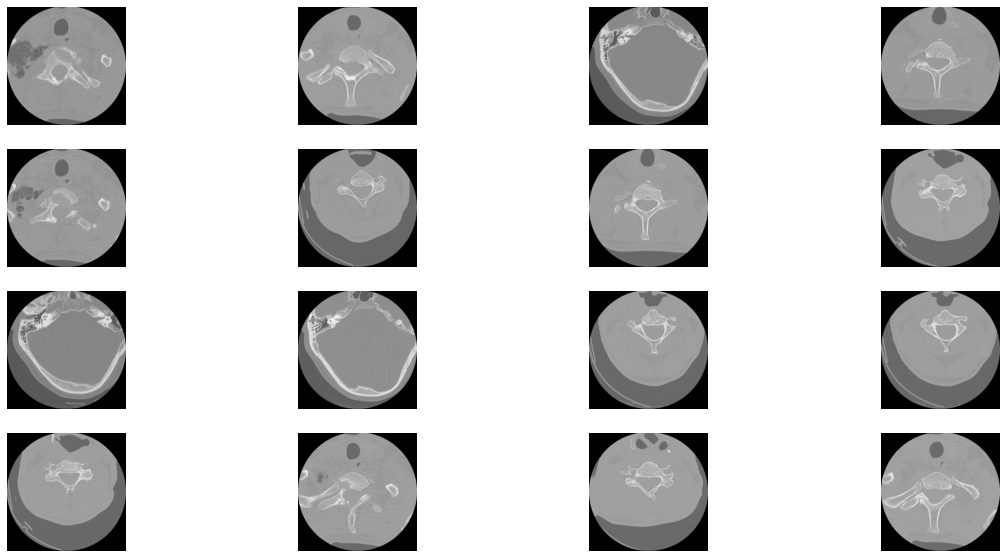

In [9]:
image_file = glob.glob("/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001/*.dcm")
plt.figure(figsize=(20, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    image_path = image_file[i]
    image = load_dicom(image_path)
    plt.axis('off')   
    plt.imshow(image)

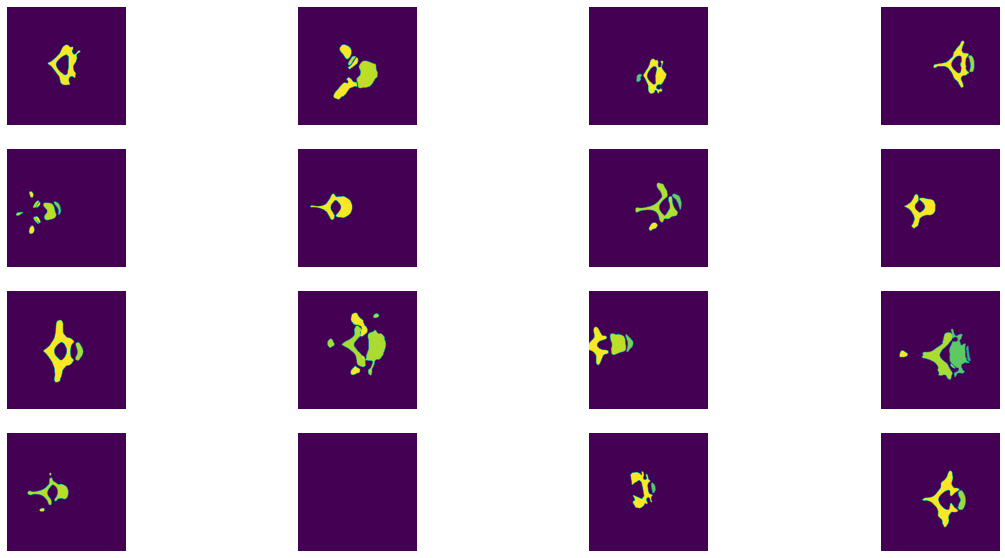

In [10]:
image_file = glob.glob("/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/*.nii")
plt.figure(figsize=(20, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    image_path = image_file[i]
    nii_img = nib.load(image_path).get_fdata()
    nib_image = nii_img[:,:,59]
    plt.axis('off')
    plt.imshow(nib_image)

In [11]:
def RSNATrainGenerator(train_df, batch_size, infinite = True, base_path = train_images_dir):
    while True:
        trainset = []
        trainidt = []
        trainlabel = []
        for i in (range(len(train_df))):
            idt = train_df.loc[i, 'StudyInstanceUID']
            path = os.path.join(base_path, idt)
            for im in os.listdir(path):
                dc = dicom.read_file(os.path.join(path,im))
                if dc.file_meta.TransferSyntaxUID.name =='JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])':
                    continue
                img = load_dicom(os.path.join(path , im))
                img = cv2.resize(img, (128 , 128))
                image = img_to_array(img)
                image = image / 255.0
                trainset += [image]
                cur_label = []
                cur_label.append(train_df.loc[i,'C1'])
                cur_label.append(train_df.loc[i,'C2'])
                cur_label.append(train_df.loc[i,'C3'])
                cur_label.append(train_df.loc[i,'C4'])
                cur_label.append(train_df.loc[i,'C5'])
                cur_label.append(train_df.loc[i,'C6'])
                cur_label.append(train_df.loc[i,'C7'])
                trainlabel += [cur_label]
                trainidt += [idt]
                if len(trainidt) == batch_size:                    
                    yield np.array(trainset), np.array(trainlabel)
                    trainset, trainlabel, trainidt = [], [], []
            i+=1

In [12]:
def RSNATestGenerator(test_df, batch_size, infinite = True, base_path = test_images_dir):
    while 1:        
        testset=[]
        testidt=[]
        for i in (range(len(test_df))):        
            if type(test_df) is list: idt = test_df[i]
            else: idt = test_df['StudyInstanceUID'].iloc[i]
            path = os.path.join(base_path, idt)
            if os.path.exists(path):
                for im in os.listdir(path):
                    dc = dicom.read_file(os.path.join(path,im))
                    if dc.file_meta.TransferSyntaxUID.name =='JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])':
                        continue
                    img=load_dicom(os.path.join(path,im))
                    img=cv2.resize(img,(128, 128))
                    image=img_to_array(img)
                    image=image/255.0
                    testset+=[image]
                    testidt+=[idt]
                    if len(testset) == batch_size:                        
                        yield np.array(testset)
                        testset = []
        if len(testset) > 0: yield np.array(testset)
        if not infinite: break

In [13]:
def get_model():
    inp = tfl.Input((None, None ,1))
    x = tfl.Conv2D(3, 3, padding = 'SAME')(inp)
    x = efficientnet.EfficientNetB5(include_top=False, weights='../input/efficientnet-weights-for-keras/noisy-student/notop/efficientnet-b5_noisy-student_notop.h5')(x)
    x = tfl.GlobalAveragePooling2D()(x)
    out = tfl.Dense(7, 'sigmoid')(x)
    model = tf.keras.models.Model(inp, out)
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001))
    return model

In [14]:
for train_idx, val_idx in StratifiedKFold(5).split(df_train, df_train['patient_overall']):    
    K.clear_session()
    x_train = df_train.iloc[train_idx].reset_index()
    x_val = df_train.iloc[val_idx].reset_index()
    model = get_model()
    hist = model.fit_generator(                            
                                    RSNATrainGenerator(x_train, min(len(x_train), 64), infinite = False, base_path = train_images_dir),
                                    epochs = 5,
                                    verbose = 1,
                                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)],
                                    validation_steps = max((len(x_val) // 64), 1),
                                    steps_per_epoch = max((len(x_train) // 64), 1),
                                    validation_data = RSNATrainGenerator(x_val, min(len(x_val), 64), infinite = False, base_path = train_images_dir),
                              )
    val_pred = model.predict_generator(RSNATestGenerator(x_val, min(len(df_test), 64), infinite = False, base_path = train_images_dir), steps = max((len(df_test) // 64), 1))    
    try: # the best we can do at the moment..
        preds = model.predict_generator(RSNATestGenerator(df_test, min(len(df_test), 64), infinite = False, base_path = test_images_dir), steps = max((len(df_test) // 64), 1))
        
        new_preds = []
        for pred_idx in range(len(preds)):
            new_preds.append(preds[pred_idx][prediction_type_mapping[pred_idx]])
        # submission['fractured'] += preds[:, prediction_type_mapping] / 5
        submission['fractured'] += np.array(new_preds) / 5
        
    except: traceback.print_exc()    

2022-12-31 23:12:52.822842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:12:52.926920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:12:52.927688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:12:52.929480: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     30        
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 28,527,893
Trainable params: 28,355,157
Non-trainable params: 172,736
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-31 23:13:03.320653: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-12-31 23:13:23.960635: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 63s 1s/step - loss: 0.4372 - val_loss: 0.4997
Epoch 2/5
25/25 [==============================] - 40s 2s/step - loss: 0.1412 - val_loss: 0.7801
Epoch 3/5
25/25 [==============================] - 33s 1s/step - loss: 0.5987 - val_loss: 0.4357
Epoch 4/5
25/25 [==============================] - 37s 2s/step - loss: 0.2970 - val_loss: 0.5574
Epoch 5/5
25/25 [==============================] - 39s 2s/step - loss: 0.5246 - val_loss: 0.2529


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     30        
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 28,527,893
Trainable params: 28,355,157
Non-trainable params: 172,736
_________________________________________________________________
Epoch 1/5
25/25 [==============================] - 40s 826ms/step - loss: 0.6146 - val_loss: 0.4778
Epoch 2/5

In [15]:
train_data = RSNATrainGenerator(df_train, 64)
sample = next(train_data)
print("input_shape:", sample[0].shape)
print("target_shape:", sample[1].shape)

input_shape: (64, 128, 128, 3)
target_shape: (64, 7)


In [16]:
def get_model5():       
    eff_model = tf.keras.applications.ResNet152(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)
    for layer in eff_model.layers[:-10]:
        layer.trainable = False
        
        
    inp = tfl.Input((128, 128 ,3))
    x = eff_model(inp)

    out = tfl.Dense(7, 'sigmoid')(x)
    model = tf.keras.models.Model(inp, out)
    model.layers[2].trainable = False
    model.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001))
    model.summary()
    return model

In [32]:
get_model().layers[1].layers

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     30        
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 28,527,893
Trainable params: 28,355,157
Non-trainable params: 172,736
_________________________________________________________________


AttributeError: 'Conv2D' object has no attribute 'layers'

In [52]:
def get_model6():       
    eff_model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
    for layer in resnet_model.layers[:-10]:
        layer.trainable = False
        
        
    inp = tfl.Input((128, 128 ,3))
    x = eff_model(inp)

    out = tfl.Dense(7, 'sigmoid')(x)
    model = tf.keras.models.Model(inp, out)
    model.layers[2].trainable = False
    model.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001))
    model.summary()
    return model


In [53]:
get_model().layers[1].layers

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 3)     30        
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 14343     
Total params: 28,527,893
Trainable params: 28,355,157
Non-trainable params: 172,736
_________________________________________________________________


AttributeError: 'Conv2D' object has no attribute 'layers'

In [36]:
for train_idx, val_idx in StratifiedKFold(5).split(df_train, df_train['patient_overall']):    
    K.clear_session()
    x_train = df_train.iloc[train_idx].reset_index()
    x_val = df_train.iloc[val_idx].reset_index()
    model = get_model()
    
    hist = model.fit_generator(                            
        RSNATrainGenerator(x_train, min(len(x_train), 64), infinite = False, base_path = train_images_dir),
        epochs = 5,
        verbose = 1,
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)],
        validation_steps = max((len(x_val) // 64), 1),
        steps_per_epoch = max((len(x_train) // 64), 1),
        validation_data = RSNATrainGenerator(x_val, min(len(x_val), 64), infinite = False, base_path = train_images_dir),
  )
    val_pred = model.predict_generator(RSNATestGenerator(x_val, min(len(df_test), 64), infinite = False, base_path = train_images_dir), steps = max((len(df_test) // 64), 1))    
    try: # the best we can do at the moment..
        preds = model.predict_generator(RSNATestGenerator(df_test, min(len(df_test), 64), infinite = False, base_path = test_images_dir), steps = max((len(df_test) // 64), 1))
        
        new_preds = []
        for pred_idx in range(len(preds)):
            new_preds.append(preds[pred_idx][prediction_type_mapping[pred_idx]])
        # submission['fractured'] += preds[:, prediction_type_mapping] / 5
        submission['fractured'] += np.array(new_preds) / 5
        
    except: traceback.print_exc()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     30        
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 28,527,893
Trainable params: 28,355,157
Non-trainable params: 172,736
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
25/25 [==============================] - 57s 1s/step - loss: 0.4803 - val_loss: 0.5175
Epoch 2/5
25/25 [==============================] - 41s 2s/step - loss: 0.1547 - val_loss: 0.7485
Epoch 3/5
25/25 [==============================] - 32s 1s/step - loss: 0.5807 - val_loss: 0.4692
Epoch 4/5
25/25 [==============================] - 32s 1s/step - loss: 0.2930 - val_loss: 0.5388
Epoch 5/5
25/25 [==============================] - 33s 1s/step - loss: 0.4928 - val_loss: 0.1767


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     30        
_________________________________________________________________
efficientnet-b5 (Functional) (None, None, None, 2048)  28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 28,527,893
Trainable params: 28,355,157
Non-trainable params: 172,736
_________________________________________________________________
Epoch 1/5
25/25 [==============================] - 48s 1s/step - loss: 0.6046 - val_loss: 0.3101
Epoch 2/5
25

In [47]:
for train_idx, val_idx in StratifiedKFold(5).split(df_train, df_train['patient_overall']):    
    K.clear_session()
    x_train = df_train.iloc[train_idx].reset_index()
    x_val = df_train.iloc[val_idx].reset_index()
    model = get_model6()
    
    hist = model.fit_generator(                            
        RSNATrainGenerator(x_train, min(len(x_train), 64), infinite = False, base_path = train_images_dir),
        epochs = 5,
        verbose = 1,
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)],
        validation_steps = max((len(x_val) // 64), 1),
        steps_per_epoch = max((len(x_train) // 64), 1),
        validation_data = RSNATrainGenerator(x_val, min(len(x_val), 64), infinite = False, base_path = train_images_dir),
  )
    val_pred = model.predict_generator(RSNATestGenerator(x_val, min(len(df_test), 64), infinite = False, base_path = train_images_dir), steps = max((len(df_test) // 64), 1))    
    try: # the best we can do at the moment..
        preds = model.predict_generator(RSNATestGenerator(df_test, min(len(df_test), 64), infinite = False, base_path = test_images_dir), steps = max((len(df_test) // 64), 1))
        
        new_preds = []
        for pred_idx in range(len(preds)):
            new_preds.append(preds[pred_idx][prediction_type_mapping[pred_idx]])
        # submission['fractured'] += preds[:, prediction_type_mapping] / 5
        submission['fractured'] += np.array(new_preds) / 5
        
    except: traceback.print_exc()

553476096/553467096 [==============================] - 32s 0us/step


ValueError: Input 0 of layer fc1 is incompatible with the layer: expected axis -1 of input shape to have value 25088 but received input with shape (None, 8192)

In [45]:
submission

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.559796
1,1.2.826.0.1.3680043.10454_C1,0.538829
2,1.2.826.0.1.3680043.10690_C1,0.525725


In [46]:
submission.to_csv('submission.csv', index = 0)